In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import random

In [14]:
# Load ratings data
ratings_data=pd.read_csv("ratings.csv")

In [15]:
# Load movies data
movies_data=pd.read_csv("movies.csv")

In [16]:
# Merge ratings and movies data
merged_data = pd.merge(ratings_data, movies_data, on='movieId')

In [17]:
df = pd.read_csv('ratings.csv',
                          error_bad_lines=False,
                          warn_bad_lines=False,
                          skiprows=lambda i: i>0 and random.random() > 0.002)
print(len(df))

<ipython-input-17-75d8d0fb4d40>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv('ratings.csv',
<ipython-input-17-75d8d0fb4d40>:1: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv('ratings.csv',


1105


In [18]:
df=df[0:20000]

In [19]:
import pandas as pd
movies = pd.read_csv("movies.csv")

In [20]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [21]:
import re

def clean_title(title):
    title = re.sub("[^a-zA-Z0-9 ]", "", title)
    return title

In [22]:

movies["clean_title"] = movies["title"].apply(clean_title)

In [23]:
movies

,movieId,title,genres,clean_title
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story 1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,Jumanji 1995
2,3,Grumpier Old Men (1995),Comedy|Romance,Grumpier Old Men 1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Waiting to Exhale 1995
4,5,Father of the Bride Part II (1995),Comedy,Father of the Bride Part II 1995
...,...,...,...,...
62418,209157,We (2018),Drama,We 2018
62419,209159,Window of the Soul (2001),Documentary,Window of the Soul 2001
62420,209163,Bad Poems (2018),Comedy|Drama,Bad Poems 2018
62421,209169,A Girl Thing (2001),(no genres listed),A Girl Thing 2001


In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,2))

tfidf = vectorizer.fit_transform(movies["clean_title"])

In [25]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def search(title):
    title = clean_title(title)
    query_vec = vectorizer.transform([title])
    similarity = cosine_similarity(query_vec, tfidf).flatten()
    indices = np.argpartition(similarity, -5)[-5:]
    results = movies.iloc[indices].iloc[::-1]

    return results

In [26]:
import ipywidgets as widgets
from IPython.display import display

movie_input = widgets.Text(
    value='Toy Story',
    description='Movie Title:',
    disabled=False
)
movie_list = widgets.Output()

def on_type(data):
    with movie_list:
        movie_list.clear_output()
        title = data["new"]
        if len(title) > 5:
            display(search(title))

movie_input.observe(on_type, names='value')


display(movie_input, movie_list)

Text(value='Toy Story', description='Movie Title:')

Output()

In [27]:
movie_id = 89745

#def find_similar_movies(movie_id):
movie = movies[movies["movieId"] == movie_id]

In [28]:
ratings = pd.read_csv("ratings.csv")

In [29]:

ratings.dtypes

userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object

In [30]:
similar_users = ratings[(ratings["movieId"] == movie_id) & (ratings["rating"] > 4)]["userId"].unique()

In [31]:
similar_user_recs = ratings[(ratings["userId"].isin(similar_users)) & (ratings["rating"] > 4)]["movieId"]

In [32]:

similar_user_recs = similar_user_recs.value_counts() / len(similar_users)

similar_user_recs = similar_user_recs[similar_user_recs > .10]

In [33]:
all_users = ratings[(ratings["movieId"].isin(similar_user_recs.index)) & (ratings["rating"] > 4)]

In [34]:
all_user_recs = all_users["movieId"].value_counts() / len(all_users["userId"].unique())

In [35]:
rec_percentages = pd.concat([similar_user_recs, all_user_recs], axis=1)
rec_percentages.columns = ["similar", "all"]

In [36]:
rec_percentages

,similar,all
89745,1.000000,0.043491
58559,0.558442,0.136402
79132,0.500000,0.124541
59315,0.480519,0.052245
2571,0.454545,0.241457
...,...,...
76251,0.103896,0.014685
81591,0.103896,0.026264
109374,0.103896,0.036713
6333,0.103896,0.029088


In [37]:
rec_percentages["score"] = rec_percentages["similar"] / rec_percentages["all"]

In [38]:
rec_percentages = rec_percentages.sort_values("score", ascending=False)

In [39]:

rec_percentages.head(10).merge(movies, left_index=True, right_on="movieId")

,similar,all,score,movieId,title,genres,clean_title
17067,1.000000,0.043491,22.993506,89745,"Avengers, The (2012)",Action|Adventure|Sci-Fi|IMAX,Avengers The 2012
16312,0.142857,0.008755,16.317972,86332,Thor (2011),Action|Adventure|Drama|Fantasy|IMAX,Thor 2011
25061,0.123377,0.007907,15.602737,122900,Ant-Man (2015),Action|Adventure|Sci-Fi,AntMan 2015
16725,0.162338,0.010449,15.536153,88140,Captain America: The First Avenger (2011),Action|Adventure|Sci-Fi|Thriller|War,Captain America The First Avenger 2011
19678,0.194805,0.012708,15.329004,102125,Iron Man 3 (2013),Action|Sci-Fi|Thriller|IMAX,Iron Man 3 2013
21348,0.279221,0.018921,14.757027,110102,Captain America: The Winter Soldier (2014),Action|Adventure|Sci-Fi|IMAX,Captain America The Winter Soldier 2014
25058,0.207792,0.014120,14.715844,122892,Avengers: Age of Ultron (2015),Action|Adventure|Sci-Fi,Avengers Age of Ultron 2015
21606,0.259740,0.018356,14.149850,111362,X-Men: Days of Future Past (2014),Action|Adventure|Sci-Fi,XMen Days of Future Past 2014
25071,0.207792,0.015250,13.625782,122920,Captain America: Civil War (2016),Action|Sci-Fi|Thriller,Captain America Civil War 2016
16527,0.201299,0.016662,12.081334,87232,X-Men: First Class (2011),Action|Adventure|Sci-Fi|Thriller|War,XMen First Class 2011


In [40]:
def find_similar_movies(movie_id):
    similar_users = ratings[(ratings["movieId"] == movie_id) & (ratings["rating"] > 4)]["userId"].unique()
    similar_user_recs = ratings[(ratings["userId"].isin(similar_users)) & (ratings["rating"] > 4)]["movieId"]
    similar_user_recs = similar_user_recs.value_counts() / len(similar_users)

    similar_user_recs = similar_user_recs[similar_user_recs > .10]
    all_users = ratings[(ratings["movieId"].isin(similar_user_recs.index)) & (ratings["rating"] > 4)]
    all_user_recs = all_users["movieId"].value_counts() / len(all_users["userId"].unique())
    rec_percentages = pd.concat([similar_user_recs, all_user_recs], axis=1)
    rec_percentages.columns = ["similar", "all"]

    rec_percentages["score"] = rec_percentages["similar"] / rec_percentages["all"]
    rec_percentages = rec_percentages.sort_values("score", ascending=False)
    return rec_percentages.head(10).merge(movies, left_index=True, right_on="movieId")[["score", "title", "genres"]]

In [41]:
import ipywidgets as widgets
from IPython.display import display

movie_name_input = widgets.Text(
    value='Toy Story',
    description='Movie Title:',
    disabled=False
)
recommendation_list = widgets.Output()

def on_type(data):
    with recommendation_list:
        recommendation_list.clear_output()
        title = data["new"]
        if len(title) > 5:
            results = search(title)
            movie_id = results.iloc[0]["movieId"]
            display(find_similar_movies(movie_id))

movie_name_input.observe(on_type, names='value')

display(movie_name_input, recommendation_list)

Text(value='Toy Story', description='Movie Title:')

Output()

In [42]:
data = pd.merge(movies,ratings,on='movieId')
data.head()

,movieId,title,genres,clean_title,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story 1995,2,3.5,1141415820
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story 1995,3,4.0,1439472215
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story 1995,4,3.0,1573944252
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story 1995,5,4.0,858625949
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Toy Story 1995,8,4.0,890492517


In [43]:
n_users = len(ratings['userId'].unique())
n_movies = len(movies['title'].unique())
n_factors = 10 # Can use any value we like

In [44]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score
from torch.utils.data import Dataset, DataLoader

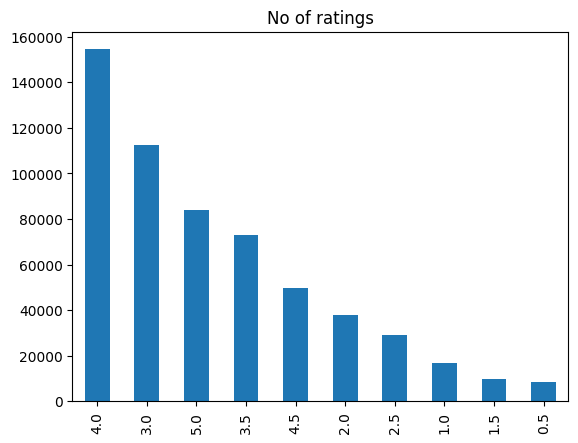

In [45]:
data['rating'].value_counts().plot(kind='bar',title='No of ratings')
plt.show()

In [46]:
def compute_map(y_true, y_score, k=None):
    """
    Compute mean average precision (MAP) given a list of ground-truth ratings and predicted scores.

    Args:
        y_true (list): List of ground-truth ratings, where each element is either 0 (negative) or 1 (positive).
        y_score (list): List of predicted scores, where each element is a real number between 0 and 1.
        k (int, optional): The maximum number of items to consider. If None, consider all items. Defaults to None.

    Returns:
        float: The mean average precision (MAP) score.
    """
    if k is not None:
        y_true = y_true[:k]
        y_score = y_score[:k]

    # Sort the items by score in descending order
    sorted_indices = sorted(range(len(y_score)), key=lambda i: y_score[i], reverse=True)
    y_true_sorted = [y_true[i] for i in sorted_indices]

    # Compute the average precision at each position
    ap = 0.0
    tp = 0.0
    fp = 0.0
    for i, label in enumerate(y_true_sorted):
        if label == 1:
            tp += 1.0
        else:
            fp += 1.0
        ap += tp / (tp + fp) * label

    # Compute the mean average precision
    if sum(y_true) > 0:
        map_score = ap / sum(y_true)
    else:
        map_score = 0.0

    return map_score

In [47]:
class RecSys(nn.Module):
    def __init__(self,n_users,n_movies,embedding_size):
        super(RecSys,self).__init__()
        self.user_embedding = nn.Embedding(n_users,embedding_size)
        self.movie_embedding = nn.Embedding(n_movies,embedding_size)
        self.user_bias = nn.Embedding(n_users,1)
        self.movie_bias = nn.Embedding(n_movies,1)
        self.fc1 = nn.Linear(embedding_size*2,128)
        self.fc2 = nn.Linear(128,64)
        self.fc3 = nn.Linear(64,1)
        self.dropout = nn.Dropout(0.5)

    def forward(self,user_ids,movie_ids):
        user_embedded = self.user_embedding(user_ids)
        movie_embedded = self.movie_embedding(movie_ids)
        user_bias = self.user_bias(user_ids)
        movie_bias = self.movie_bias(movie_ids)
        x = torch.cat([user_embedded,movie_embedded],dim=1)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = nn.ReLU()(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = x + user_bias + movie_bias
        return x

In [48]:
# Convert user and item IDs to integers
user_ids = {id: i for i, id in enumerate(data['userId'].unique())}
movie_ids = {id: i for i, id in enumerate(data['movieId'].unique())}
data['userId'] = data['userId'].apply(lambda x: user_ids[x])
data['movieId'] = data['movieId'].apply(lambda x: movie_ids[x])

# Split the data into training and test sets
train_data = data.sample(frac=0.8, random_state=123)
test_data = data.drop(train_data.index)

# Define a PyTorch Dataset for the training and test sets
class RatingDataset(Dataset):
    def __init__(self, data):
        self.user_ids = data['userId'].values
        self.movie_ids = data['movieId'].values
        self.ratings = data['rating'].values

    def __len__(self):
        return len(self.user_ids)

    def __getitem__(self, idx):
        user_id = self.user_ids[idx]
        movie_id = self.movie_ids[idx]
        rating = self.ratings[idx]
        return user_id, movie_id, rating

train_dataset = RatingDataset(train_data)
test_dataset = RatingDataset(test_data)

# Define PyTorch DataLoaders for the training and test sets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## Initialize model and optimizer
model = RecSys(n_users,n_movies,n_factors)
optimizer = optim.AdamW(model.parameters(),lr=0.015)

In [49]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

def train(train_loader,optimizer,num_epochs):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for user_id, movie_id, rating in train_loader:
            user_id = user_id.to(device) ## Move to GPU for faster processing
            movie_id = movie_id.to(device)
            optimizer.zero_grad()  # Set gradients to zero
            outputs = model(user_id, movie_id)
            loss = compute_map(rating, outputs)
            loss = torch.tensor(loss, requires_grad=True)  # Wrap in Variable with requires_grad=True
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1} MAP: {running_loss/len(train_loader)}")

def evaluate(test_loader, model):
    model.eval()  # Set the model to evaluation mode

    running_loss = 0.0
    num_samples = 0

    for user_id, movie_id, rating in test_loader:
        with torch.no_grad():  # Disable gradient computation during evaluation
            outputs = model(user_id.to(device), movie_id.to(device))
            loss = compute_map(rating, outputs.cpu())
            running_loss += loss.item()
            num_samples += 1

    map_score = running_loss / num_samples
    return map_score

In [50]:
train(train_loader,optimizer,num_epochs=1)
print(evaluate(test_loader, model))

<ipython-input-49-0efa3536f207>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.tensor(loss, requires_grad=True)  # Wrap in Variable with requires_grad=True


Epoch 1 MAP: 0.02672271529170396
0.027249957064261032


In [51]:
import csv

# Create a dictionary mapping movie IDs to their titles
movie_id_to_title = {}
with open('movies.csv', 'r', encoding='utf8') as f:
    reader = csv.reader(f)
    next(reader)  # Skip header row
    for row in reader:
        movie_id = int(row[0])
        title = row[1]
        movie_id_to_title[movie_id] = title

In [52]:
def recommend_movies(model, user_id, top_n=10):
    # Get the movie IDs for all movies
    movie_ids = torch.arange(n_movies)

    # Repeat the user ID for all movies
    user_ids = torch.full((n_movies,), user_id)

    # Get the predicted ratings for all movies by the given user
    ratings = model(user_ids, movie_ids)

    # Sort the movie IDs by predicted rating in descending order
    sorted_indices = torch.argsort(ratings, descending=True)

    # Get the top N movie IDs
    top_indices = sorted_indices[:top_n]

    # Convert the indices to movie IDs
    top_movie_ids = [int(movie_ids[i]) for i in top_indices]

    # Get the movie titles for the top N movie IDs
    top_movie_titles = []
    for movie_id in top_movie_ids:
        if movie_id in movie_id_to_title:
            top_movie_titles.append(movie_id_to_title[movie_id])
        else:
            top_movie_titles.append(f"Movie Id:{movie_id}")

    return top_movie_titles

recommend_movies(model, user_id=12, top_n=10) ## Not best of function to retrieve recommendations
## It is better to retrieve recommendation from the embedding created by the model

['Movie Id:0',
 'Movie Id:0',
 'Movie Id:0',
 'Movie Id:0',
 'Movie Id:0',
 'Movie Id:0',
 'Movie Id:0',
 'Movie Id:0',
 'Movie Id:0',
 'Movie Id:0']

In [53]:
# Split the data into training and testing sets
trainset, testset = train_test_split(data, test_size=0.25)
print(type(trainset))

<class 'pandas.core.frame.DataFrame'>


In [54]:
train(train_loader,optimizer,num_epochs=1)
print(evaluate(test_loader, model))

<ipython-input-49-0efa3536f207>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.tensor(loss, requires_grad=True)  # Wrap in Variable with requires_grad=True


Epoch 1 MAP: 0.026780151333599567
0.027249957064261032
